## Imports

In [2]:
import numpy as np
import pandas as pd
import pylab as pl
import seaborn as sns
sns.set_theme()

from IPython.display import clear_output
from tqdm.notebook import trange

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

from utils import *
from document_cleaner import *

## Load data

### From disk

In [2]:
data = pd.read_json("data/News_Category_Dataset_v2.json", lines=True)

## Data cleaning

In [3]:
# Save the old category column
data['old_category'] = data["category"]

In [4]:
data['category'] = data['category'].replace({"HEALTHY LIVING": "WELLNESS",
                                             "STYLE": "STYLE & BEAUTY",
                                             "PARENTS": "PARENTING",
                                             "TASTE": "FOOD & DRINK",
                                             "BUSINESS": "BUSINESS & FINANCE",
                                             "MONEY": "BUSINESS & FINANCE",
                                             "THE WORLDPOST": "WORLD NEWS",
                                             "WORLDPOST": "WORLD NEWS",
                                             "TECH": "SCIENCE & TECH",
                                             "SCIENCE": "SCIENCE & TECH",
                                             "GREEN": "ENVIRONMENT",
                                             "CULTURE & ARTS": "ARTS & CULTURE",
                                             "ARTS": "ARTS & CULTURE",
                                             "COLLEGE": "EDUCATION"})


In [5]:
data["full_text"] = data["headline"] + ". " + data["short_description"]

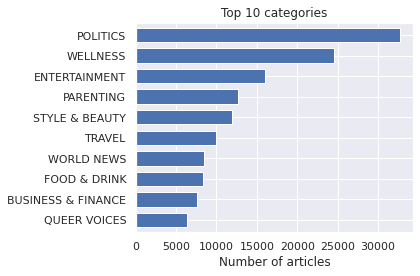

In [6]:
data["category"].value_counts()[:10][::-1].plot.barh(title="Top 10 categories", width=0.7)
pl.xlabel('Number of articles')
pl.savefig("top_10_categories.png", dpi=200)

In [7]:
documents, labels = data["full_text"].to_numpy(), data["category"].to_numpy()

In [8]:
# Clean documents, by default, removes punctuation, numbers, lowercases all words,
# removes stopwords, hashtags and performs stemming
cleaner = DocumentCleaner()
cleaned_documents = cleaner.clean(documents)

Stemming documents:   0%|          | 0/200853 [00:00<?, ?it/s]

Removing stopwords:   0%|          | 0/200853 [00:00<?, ?it/s]

### Collocations

In [9]:
# Finds bigram collocations in the cleaned documents, without considering words with less than 2 characters
# bigrams with less than 10 occurrences
collocations = find_collocations(cleaned_documents)
collocations.head(10)

,bigram,pmi
0,"(donald, trump)",2047.863099
1,"(hillari, clinton)",1054.000462
2,"(berni, sander)",534.781150
3,"(new, york)",501.561828
4,"(suprem, court)",457.214420
5,"(los, angel)",351.713647
6,"(ted, cruz)",271.381164
7,"(taylor, swift)",262.431148
8,"(tumblr, pinterest)",253.041254
9,"(marco, rubio)",224.848895


In [10]:
# Join collocations on the cleaned documents
set_collocations = collocations.sort_values(by='pmi', ascending=False).head(1000)["bigram"].to_list()
cleaned_documents = apply_collocations(cleaned_documents, set_collocations)

Documents processed:   0%|          | 0/200853 [00:00<?, ?it/s]

In [11]:
# Store cleaned documents and remove rows where full_text_cleaned is nan or empty
data["full_text_cleaned"] = cleaned_documents
data['full_text_cleaned'].replace(['', ' '], np.nan, inplace=True)
data.dropna(subset=["full_text_cleaned"], inplace=True)

In [12]:
# Convert string to datetime format
data['date'] = pd.to_datetime(data['date'])
# Remove link column so that I can upload the train/test set to github
data.drop(columns=["link"], inplace=True) 

In [13]:
# Save full dataset to csv
data.to_csv("data/news_data.csv", index=False)

In [14]:
# Save test and train set to csv
data[data["date"].dt.year.isin(list(range(2012, 2018)))].to_csv("data/test_data.csv", index=False)
data[data["date"].dt.year.isin(list(range(2017, 2019)))].to_csv("data/test_data.csv", index=False)

## Data exploration

In [3]:
data = pd.read_csv("data/news_data.csv")
cleaned_documents = data["full_text_cleaned"].to_numpy()

### Word cloud

In [4]:
from wordcloud import WordCloud
from PIL import Image

In [5]:
%matplotlib qt
text = ' '.join(documents_to_words(cleaned_documents))
mask = np.array(Image.open("USA_Flag_Map.png"))
wordcloud = WordCloud(max_font_size=160,
                      colormap=pl.get_cmap("viridis"),
                      background_color="white",
                      min_word_length=2,
                      mask=255-mask[:, :, -1]).generate(text)
pl.imshow(wordcloud, interpolation="bilinear")
pl.axis("off")
pl.show()
pl.savefig("wordcloud.png", dpi=300, bbox_inches="tight")


### T-SNE

In [6]:
# filter data to the 10most probable classes
data_filtered = data[data.category.isin(data.category.value_counts().head(10).index)]
X, y = data_filtered["full_text_cleaned"].to_numpy(), data_filtered["category"].to_numpy()

# shuffle data
perm = np.random.permutation(X.shape[0])
X = X[perm]
y = y[perm]

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder().fit(y)
y = le.transform(y)

X = TfidfVectorizer(ngram_range=(1, 1),
                    stop_words='english',
                    strip_accents="unicode",
                    analyzer='word',
                    min_df=0.001,
                    max_df=0.7,
                    sublinear_tf=True,
                    use_idf=True).fit_transform(X)


In [8]:
import numpy as np
from sklearn.manifold import TSNE

n_samples = 10000

t_sne = TSNE(n_components=2, verbose=1, perplexity=50).fit(X[:n_samples])
clear_output()

In [10]:
# Plot the classes in the embedding space
group = y[:n_samples]
X_embedded = t_sne.embedding_

fig, ax = pl.subplots()
for g in range(10):
    if g in [3, 5, 0]:
        ax.scatter(X_embedded[group==g, 0], X_embedded[group==g, 1], label=le.classes_[g], s=7, alpha=0.5, color=pl.cm.get_cmap("tab10")(g))
    else:
        ax.scatter(X_embedded[group==g, 0], X_embedded[group==g, 1], s=7, alpha=0.5, color=pl.cm.get_cmap("tab10")(g))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=False)
pl.savefig("tsne.svg", dpi=300, bbox_inches="tight")

## Topic modeling

### SVD/NMF [Not used]

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), 
                                   stop_words='english', 
                                   analyzer='word', 
                                   min_df=0.001, 
                                   max_df=0.7, 
                                   sublinear_tf=True, 
                                   use_idf=True)

X = tfidf_vectorizer.fit_transform(data["full_text_cleaned"])

In [33]:
from sklearn.decomposition import TruncatedSVD
# set number of latent components
k = 50

svd = TruncatedSVD(n_components=k)
U = svd.fit_transform(X)
S = svd.singular_values_
V = svd.components_

In [23]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=k, init='nndsvd', random_state=0)

W = nmf.fit_transform(X)
H = nmf.components_

In [56]:
terms = tfidf_vectorizer.get_feature_names()

show_topics(V, terms)

['make, new, time, photo, day',
 'trump, donald_trump, presid, say, republican',
 'photo, 0000, look, week, new',
 'new, 0000, year, world, time',
 'new, make, photo, trump, video']

### sklearn LDA [Not used]

In [61]:
# shuffle data
X = data["full_text_cleaned"].to_numpy()
perm = np.random.permutation(X.shape[0])
X = X[perm]

In [62]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,1), 
                                   stop_words='english', 
                                   analyzer='word', 
                                   min_df=50, 
                                   max_df=0.5,
                                   sublinear_tf=True).fit(X)

X = vectorizer.transform(X)
lda = LatentDirichletAllocation(n_components=5, random_state=0,verbose=1)
lda.fit(X[:10000])

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


LatentDirichletAllocation(n_components=5, random_state=0, verbose=1)

In [63]:
tokens = [np.argsort(component)[-5:] for component in lda.components_]
for token in tokens:
    print([vectorizer.get_feature_names()[i] for i in token])

['0000', 'peopl', 'say', 'way', 'polic']
['life', 'say', 'donald_trump', 'new', 'trump']
['video', 'year', 'say', '0000', 'new']
['like', 'day', 'time', 'make', 'thing']
['dress', '0000', 'wed', 'new', 'photo']


### gensim LDA

In [4]:
topics_data = data["full_text_cleaned"]

In [5]:
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.corpora import Dictionary

instances = pd.Series(remove_short_words(topics_data, 2)).apply(str.split)

# Sampling is done when choosing the number of topics with umass/cv scores
# instances = instances.sample(25000, replace=False)

dictionary = Dictionary(instances)
dictionary.filter_extremes(no_below=100, no_above=0.3)

In [6]:
ldacorpus = [dictionary.doc2bow(text) for text in instances]
tfidfmodel = TfidfModel(ldacorpus)
model_corpus = tfidfmodel[ldacorpus]

#### Umass/CV score

In [15]:
coherence_values = []

dev_size = 20000
eval_size = 5000

for num_topics in trange(4, 10):
    model = LdaMulticore(corpus=model_corpus[:dev_size], 
                         id2word=dictionary, 
                         num_topics=num_topics,
                         workers=4,
                         alpha="symmetric",
                         eta="symmetric",
                         passes=10)

    coherencemodel_umass = CoherenceModel(model=model, 
                                          texts=instances[dev_size:dev_size+eval_size], 
                                          dictionary=dictionary, 
                                          coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=model, 
                                       texts=instances[dev_size:dev_size+eval_size], 
                                       dictionary=dictionary, 
                                       coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    
    coherence_values.append((num_topics, umass_score, cv_score))

coherence_values = np.array(coherence_values)

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# plot coherence values
fig, subplots = pl.subplots(ncols=2, figsize=(10, 5))
subplots[0].plot(coherence_values[:, 0], coherence_values[:, 2])
subplots[0].set_xlabel("Number of Topics")
subplots[0].set_ylabel("Coherence score")
subplots[0].set_title("CV")
subplots[1].plot(coherence_values[:, 0], coherence_values[:, 1])
subplots[1].set_xlabel("Number of Topics")
subplots[1].set_title("u_mass")
fig.show()
pl.savefig("coherence.png", dpi=300, bbox_inches="tight")

#### Model

In [10]:
model = LdaMulticore(corpus=model_corpus,
                     id2word=dictionary,
                     num_topics=5,
                     alpha="symmetric",
                     eta="symmetric",
                     passes=20,
                     workers=4)

In [31]:
topics = pd.DataFrame([i.split(", ") for i in get_topic_descriptors(model, num_words=5)]
                      , index=["Topic {}".format(i) for i in range(1, 6)],
                      columns=["Word {}".format(i) for i in range(1, 6)])

In [33]:
topics.T

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
Word 1,photo,trump,hotel,make,studi
Word 2,video,presid,citi,get,health
Word 3,wed,donald_trump,photo,love,research
Word 4,0000,obama,travel,thing,help
Word 5,look,say,0000,time,peopl


In [13]:
# The topic descriptor are setted manually because sometime the top words are repeated
# or not informative.
descriptors = get_topic_descriptors(model, num_words=2)

In [14]:
# Get the topic distribution of each document
documents_by_topics = []
for document in tqdm(model[model_corpus], desc="Documents processed: "):
    topics = [topic for _, topic in document]
    documents_by_topics.append(topics)

topic_distros = pd.DataFrame(index=topics_data.index, data=documents_by_topics, columns=descriptors)

  0%|          | 0/200844 [00:00<?, ?it/s]

In [15]:
# Add the category and date to the dataframe
topic_distros["category"] = data["category"]
topic_distros["date"] = data["date"].astype("datetime64[ns]")

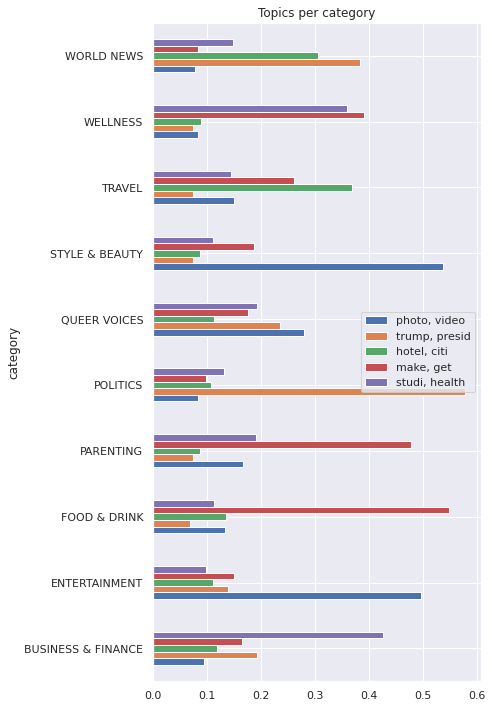

In [16]:
# Plot topics by category
most_common_categories = topic_distros.groupby("category").count().sort_values(by="date", ascending=False).index.values
topic_distros[topic_distros["category"].isin(most_common_categories[:10])].groupby("category").mean().plot.barh(figsize=(7, 10))

pl.title("Topics per category")
pl.legend(loc='center right', bbox_to_anchor=(1, 0.5), ncol=1)
pl.savefig("topics_by_category.png", dpi=300, bbox_inches="tight")

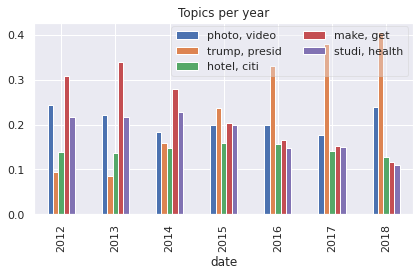

In [17]:
# Plot topics per year
topic_distros.groupby(topic_distros['date'].map(lambda x: x.year)).mean().plot.bar()
pl.legend(loc='upper right', bbox_to_anchor=(1, 1.01), ncol=2, framealpha=0.4)

pl.title("Topics per year")
pl.savefig("topics_by_year.png", dpi=300, bbox_inches="tight")

## Doc2Vec [Not used]

In [29]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import FAST_VERSION
from gensim.models.doc2vec import TaggedDocument

corpus = []

for document, label in zip(data["full_text_cleaned"], data["category"]):
    corpus.append(TaggedDocument(words=document.split(), tags=[label]))

d2v_model = Doc2Vec(vector_size=100,
                    hs=0,
                    sample=1e-4,
                    negative=5,
                    min_count=100,
                    workers=-1,
                    epochs=100,
                    dm=0, 
                    dbow_words=1)
d2v_model.build_vocab(corpus)
d2v_model.train(corpus, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)

In [33]:
label = "POLITICS"
d2v_model.dv.most_similar(str(label), topn=5)

[('LATINO VOICES', 0.2739564776420593),
 ('BLACK VOICES', 0.07782597094774246),
 ('FOOD & DRINK', 0.07342368364334106),
 ('WEIRD NEWS', 0.06434270739555359),
 ('RELIGION', 0.062377333641052246)]

# Text classification

In [121]:
test_data = pd.read_csv("data/test_data.csv")
train_data = pd.read_csv("data/train_data.csv")

X_train = train_data["full_text"]
y_train = train_data["category"]
X_test = test_data["full_text"]
y_test = test_data["category"]

In [122]:
# Encode y labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

## Naive Bayes

In [79]:
# Count vectorizer + Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
count_vectorizer = CountVectorizer(lowercase=True,
                                   min_df=0.00003,
                                   max_df=0.7,
                                   strip_accents="unicode",
                                   ngram_range=(1, 2),
                                   stop_words="english")
mnb = MultinomialNB()

In [80]:
from sklearn.pipeline import Pipeline
def make_model(vectorizer, classifier):
    return Pipeline([('vectorizer', vectorizer), ('classifier', classifier)])

model = make_model(count_vectorizer, mnb)
model.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_df=0.7, min_df=3e-05, ngram_range=(1, 2),
                                 stop_words='english',
                                 strip_accents='unicode')),
                ('classifier', MultinomialNB())])

In [81]:
get_model_report(model, X_test, y_test)

Model took 1.31 seconds to predict 38472 documents
Time per document: 0.034 ms
F1 macro: 0.36
F1 weighted: 0.61


## Logreg

In [138]:
# Tfidf vectorizer + log reg
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
tfidf_vectorizer = TfidfVectorizer(lowercase=True,
                                   min_df=0.00003,
                                   max_df=0.7,
                                   sublinear_tf=True,
                                   strip_accents="unicode",
                                   ngram_range=(1,2),
                                   stop_words="english")
logreg = LogisticRegression(n_jobs=4,
                            max_iter=1000,
                            solver="saga",
                            verbose=1,
                            tol=0.01,
                            C=3.46)


In [139]:
# Pipeline
model = make_model(tfidf_vectorizer, logreg)
model.fit(X_train, y_train)
clear_output()

In [140]:
get_model_report(model, X_test, y_test)

Model took 1.38 seconds to predict 38472 documents
Time per document: 0.036 ms
F1 macro: 0.40
F1 weighted: 0.64


## Optuna tuning

In [95]:
import optuna
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
def objective(trial):
    C = trial.suggest_float('C', 1e-4, 1e4, log=True)
    tfidf_vectorizer = TfidfVectorizer(lowercase=True,
                                   min_df=0.00003,
                                   max_df=0.7,
                                   sublinear_tf=True,
                                   strip_accents="unicode",
                                   ngram_range=(1, 2),
                                   stop_words="english")
    logreg = LogisticRegression(n_jobs=4,
                                max_iter=1000,
                                solver="saga",
                                verbose=1,
                                tol=0.03,
                                C=C)
    model = make_model(tfidf_vectorizer, logreg)
    model.fit(X_train, y_train)
    clear_output()
    return f1_score(y_val, model.predict(X_val), average='weighted')

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

[I 2022-05-30 16:32:56,733] Trial 29 finished with value: 0.6393640086858344 and parameters: {'C': 0.5203721716747812}. Best is trial 28 with value: 0.6699633580028699.


In [97]:
values = [trial.values for trial in study.trials]
params = [trial.params["C"] for trial in study.trials]
study.best_params

{'C': 3.463580963002556}

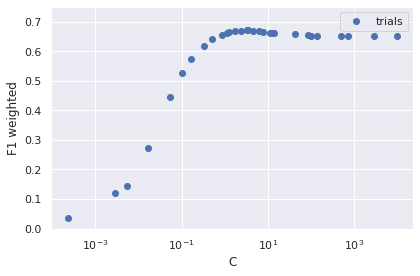

In [117]:
import seaborn
seaborn.set_theme("notebook", style="darkgrid")
pl.plot(params, values, 'o', label="trials")
pl.ylim(0., 0.75)
pl.xscale("log")
pl.xlabel("C")
pl.ylabel("F1 weighted")
pl.legend()
pl.savefig("log_reg_C.svg")

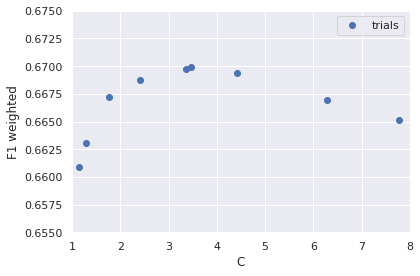

In [115]:
pl.plot(params, values, 'o', label="trials")
pl.xlim(1, 8)
pl.ylim(0.655, 0.675)
pl.xlabel("C")
pl.ylabel("F1 weighted")
pl.legend()
pl.savefig("log_reg_C2.svg")

# Final Graph

In [2]:
methods=["Naive Bayes", "Logistic Regression", "CNN", "LSTM", "Transformer"]
metrics=["F1_weighted", "F1_macro", "train_time [s]", "eval_time [us]"]
data = [[0.36, 0.61, 8, 34],
        [0.40, 0.64, 23, 35],
        [0.38, 0.58, 10*60, 90],
        [0.37, 0.58, 14*60, 130],
        [0.45, 0.68, 20*60, 1600]]

df = pd.DataFrame(data, columns = metrics, index = methods)
df.to_csv("results.csv")

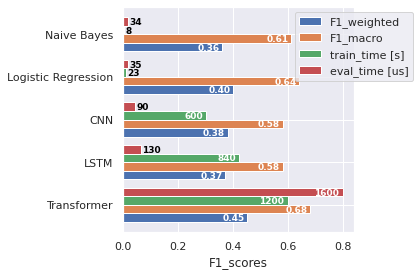

In [41]:
df[["train_time [s]", "eval_time [us]"]] = df[["train_time [s]", "eval_time [us]"]] / 2000
ax = df[::-1].plot.barh(width=0.8)

pl.legend(loc='upper center', bbox_to_anchor=(1, 1),
          ncol=1, fancybox=True, shadow=False)

for i, p in enumerate(ax.patches):
    text = f"{p.get_width():.2f}"
    if p.xy[1] % 1 < 0.6 or p.xy[1] % 1 > 0.9:
        text = f"{p.get_width()*2000:.0f}"
    if p.get_width() < 0.1:
        c = "black"
        dw = 0.005
    else:
        c = "white"
        dw = -(len(text) * 0.026 - text.count(".") * 0.015)
    ax.annotate(text, (p.get_width()+dw, p.xy[1]+0.025), color=c, weight="bold", fontsize=9)

pl.xlabel("F1_scores")
pl.savefig("metrics2.svg")

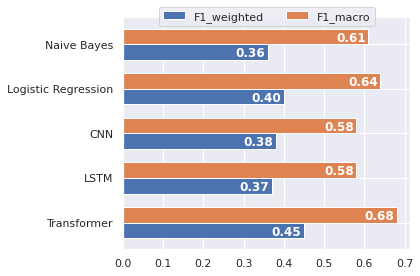

In [7]:
ax = df[["F1_weighted", "F1_macro"]][::-1].plot.barh(width=0.7)

pl.legend(loc='upper center', bbox_to_anchor=(0.5, 1.07),
          ncol=3, fancybox=True, shadow=False)

for i, p in enumerate(ax.patches):
        ax.annotate(f"{p.get_width():.2f}", (p.get_width() - 0.08, p.xy[1] + 0.07), color="white", weight="bold", fontsize=12)
pl.savefig("metrics.svg", dpi=300)

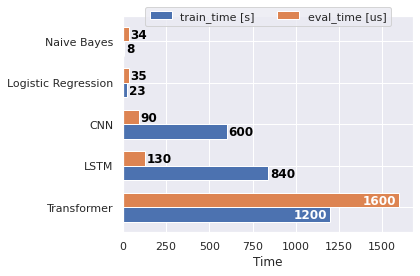

In [31]:
ax = df[["train_time [s]", "eval_time [us]"]][::-1].plot.barh(width=0.7)

pl.legend(loc='upper center', bbox_to_anchor=(0.5, 1.07),
          ncol=3, fancybox=True, shadow=False)

for i, p in enumerate(ax.patches):
        if p.xy[1] < 0:
                ax.annotate(f"{p.get_width()}", (p.get_width() - 210, p.xy[1] + 0.07), color="white", weight="bold", fontsize=12)
        else:
                ax.annotate(f"{p.get_width()}", (p.get_width()+10, p.xy[1] + 0.07), color="black", weight="bold", fontsize=12)
pl.xlabel("Time")
pl.savefig("times.png", dpi=300)